In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math
from random import randint
import scipy.stats as st
%matplotlib inline

In [2]:
def rgb2gray(rgb):
    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return gray

def gkern(kernlen=21, nsig=3):
    """Returns a 2D Gaussian kernel array."""

    interval = (2*nsig+1.)/(kernlen)
    x = np.linspace(-nsig-interval/2., nsig+interval/2., kernlen+1)
    kern1d = np.diff(st.norm.cdf(x))
    kernel_raw = np.sqrt(np.outer(kern1d, kern1d))
    kernel = kernel_raw/kernel_raw.sum()
    return kernel

In [3]:
def GetSeed(Image):
    '''Picks a random 3x3 patch in the initial sample'''
    Size=Image.shape
    cx=randint(2,Size[0]-2)
    cy=randint(2,Size[1]-2)
    Seed=Image[cx-1:cx+2,cy-1:cy+2,:]*.99
    return(Seed)

def Image2Fill(SizeX,SizeY,Image):
    '''Initialisation of the algorithm, picks a random 3x3 patch in the initial sample'''
    seed=GetSeed(Image)
    NewImage = np.empty([SizeX,SizeY,3])
    NewImage.fill(np.nan)
    NewImage[np.int(np.floor(SizeX/2))-1:np.int(np.floor(SizeX/2))+2,np.int(np.floor(SizeY/2))-1:np.int(np.floor(SizeY/2))+2]=seed
    return NewImage

def ComputeDistance(CurrentPatch,RefPatch,GKernel):
    '''Computes sum of squared error weigthed by a gaussian and adjusted for 3 channels and human perception'''
    Mask=~np.logical_and(~np.isnan(CurrentPatch),~np.isnan(RefPatch))
    RefPatch2=np.copy(RefPatch)
    CurrentPatch[Mask]=np.nan
    RefPatch2[Mask]=np.nan
    if (np.sum(~Mask*1)<6):
        return 100
    else:
        #Classic color space for human perception
        DistR=np.nansum(np.square(CurrentPatch[:,:,0]-RefPatch[:,:,0])*GKernel)/np.sum(GKernel[~Mask[:,:,0]])*0.2989
        DistG=np.nansum(np.square(CurrentPatch[:,:,1]-RefPatch[:,:,1])*GKernel)/np.sum(GKernel[~Mask[:,:,0]])*0.5870
        DistB=np.nansum(np.square(CurrentPatch[:,:,2]-RefPatch[:,:,2])*GKernel)/np.sum(GKernel[~Mask[:,:,0]])*0.1140
        return DistR+DistG+DistB

def GetUnfilledNeigbors(NewImage):
    #Generate a list with pixels position and the number of neighbors they have
    #4-Neighborhood only
    Size=np.array(NewImage.shape)
    Size[0]=Size[0]-2
    Size[1]=Size[1]-2
    Neighbors=np.zeros([Size[0]*Size[1],3],dtype=int)
    ind=0
    for i in range(1,Size[0]+1):
        for j in range(1,Size[1]+1):
            Neighbors[ind,1]=i
            Neighbors[ind,2]=j
            if ~np.isnan(NewImage[i,j,0]):
                #If the pixel has no unfilled neighbors then set to -1
                Neighbors[ind,0]=-1
            else:
                #Else set to sum of unfilled neighbors
                Patch=NewImage[i-1:i+2,j-1:j+2,0]
                Patch[1,1]=np.nan
                Neighbors[ind,0]=np.sum(~np.isnan(Patch))
            ind=ind+1
    return Neighbors

def Distance(WindowSize,Image,NewImage,Sigma,Pixelx,Pixely):
    '''Computes the distance matrix for all other patches possible in the sample'''
    SizeNewImage=np.array(NewImage.shape)
    SizeImage=np.array(Image.shape)
    GKernel=gkern(WindowSize, Sigma)
    DistMat=np.ones_like(Image[:,:,0])*100
    
    Win2 = np.int(WindowSize/2)
    
    #If the Reference Patch has no value on a spot, it is defined as nan
    RefPatch=np.empty([WindowSize,WindowSize,3])
    RefPatch.fill(np.nan)
    
    #Location of the patch from the New Image    
    minxNew=np.max([0,Pixelx-Win2])
    minyNew=np.max([0,Pixely-Win2])
    maxxNew=np.min([SizeNewImage[0],Pixelx+Win2])
    maxyNew=np.min([SizeNewImage[1],Pixely+Win2])
    
    xmPatchRef=np.max([int(WindowSize/2)-Pixelx,0])
    xMPatchRef=np.min([WindowSize,SizeNewImage[0] + int(WindowSize/2) - Pixelx])
    ymPatchRef=np.max([int(WindowSize/2)-Pixely,0])
    yMPatchRef=np.min([WindowSize,SizeNewImage[1] + int(WindowSize/2) - Pixely])
    
    #Slicing the reference patch out of the image being generated
    RefPatch[xmPatchRef:xMPatchRef,ymPatchRef:yMPatchRef,:]= NewImage[minxNew:maxxNew+1,minyNew:maxyNew+1,:]
    
    #Nested loop for generating the distance matrix
    for i in range(Win2,SizeImage[0]+1-Win2):
        for j in range(Win2,SizeImage[1]+1-Win2):
            #Location of the current patch from the sample image            
            xmPatch=np.max([Win2-i,0])
            xMPatch=np.min([WindowSize,SizeImage[0] + Win2 - i])
            ymPatch=np.max([Win2-j,0])
            yMPatch=np.min([WindowSize,SizeImage[1] + Win2 - j])
            minx=i-Win2
            miny=j-Win2
            maxx=i+Win2
            maxy=j+Win2
            
            #Current patch is filled with nan to represent pixels that haven't been generated yet
            CurrentPatch=np.empty([WindowSize,WindowSize,3])
            CurrentPatch.fill(np.nan)
            
            #Slicing the current patch out of the Sample image
            #So that the Distance can take into account the pixels generated previously
            CurrentPatch[xmPatch:xMPatch,ymPatch:yMPatch,:]=Image[minx:maxx+1,miny:maxy+1,:]
            dist=ComputeDistance(CurrentPatch,RefPatch,GKernel)
            #Allocation of the Distance matrix
            DistMat[i][j]=dist
    return DistMat


def GrowTexture(WindowSize,SizeX,SizeY,Image):
    '''Synthesis algorithm taking the patch size, output size and sample image as input'''
    #Few hyperparameters that have a low impact on the synthesis
    Threshold=0.1
    Sigma=WindowSize/6.4
    MaxErrorThresh=0.3
    count = 0
    
    #Intialisation with a 3x3 seed
    NewImage=Image2Fill(SizeX,SizeY,Image)
    Neighbors=GetUnfilledNeigbors(NewImage)
    
    #While unfilled neighbors are present, fill the image
    while(sum((Neighbors[:,0]>0)*1)>0):
        #Garantying loop termination
        progress=0
        #Select the empty pixel with the most neighbors
        posNei=np.argmax(Neighbors,0)[0]
        posNei=Neighbors[posNei,:]
        Pixelx=posNei[1]
        Pixely=posNei[2]
        #Compute the distace around the current pixel
        Dist=Distance(WindowSize,Image,NewImage,Sigma,Pixelx,Pixely)
        indicesDist=np.array(np.where(Dist<=(np.min(Dist)*(1+Threshold))))
        #Pick a random patch that has a low enough error valur
        randind=randint(0,len(indicesDist[0])-1)
        if Dist[indicesDist[0,randind],indicesDist[1,randind]] < MaxErrorThresh:
            #Allocation of the new pixel
            IndiceImage=[indicesDist[0,randind],indicesDist[1,randind]]
            NewImage[Pixelx,Pixely,:]=Image[IndiceImage[0],IndiceImage[1],:]
            progress=1
        if progress  == 0:
            #Garantying loop termination
            MaxErrorThresh=MaxErrorThresh*1.1
        count=count+1
        Neighbors=GetUnfilledNeigbors(NewImage)
    return NewImage[1:-1,1:-1]

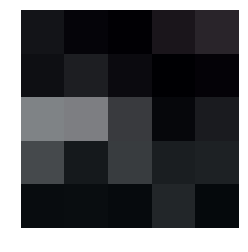

In [4]:
img=np.array(mpimg.imread('../Samples/Beries.jpg'))[:,:,:3]/255.0
# plt.imshow(img,cmap='gray')
# plt.axis('off')
# plt.show()
b=GrowTexture(9,7,7,img)
plt.imshow(b)
plt.axis('off')
plt.show()